In [21]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import torch
from torch import nn
from DeepQLearning import DeepQLearning
from learning import Agent

env = gym.make('MountainCar')
#env.seed(0)
np.random.seed(0)

## pytorch model
model = nn.Sequential(
            nn.Linear(env.observation_space.shape[0],512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,env.action_space.n)
        )

criterion = nn.MSELoss()# MSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)# ADAM


d_params = {
    "env":env,
    "gamma" : 0.99,
    "epsilon" : 1.0,
    "epsilon_min" : 0.01,
    "epsilon_dec" : 0.99,
    "episodes" : 1500,
    "batch_size" : 128,
    "memory" : deque(maxlen=10000), #talvez usar uma memoria mais curta
    "model" : model,
    "criterion" : criterion,
    "optimizer" : optimizer,
    "max_steps" : 500,
}


q_params = {
    "epsilon":0.9,
    "alpha":0.3,
    "gamma":0.99,
    "e_dec":0.999,
    "e_min":0.01,
    "algo":"q-learning",
    "env":env,
    "cont":True,
    "training":False,
    "max_episodes": 1500}






/home/andre/miniconda3/envs/cuda/lib/python3.8/site-packages/gymnasium/envs/registration.py:527: UserWarning: WARN: Using the latest versioned environment `MountainCar-v0` instead of the unversioned environment `MountainCar`.
  logger.warn(


In [22]:
def rolling(rewards,window):
    for i in range(window,len(rewards)):
         rewards[i-window:i].mean()
    return rewards

In [23]:
q_list = []
for i in range(5):
    Q = Agent(**q_params)
    Q.read_training("q-learning.txt",inplace=True)
    rewards = np.array(Q.execute())
    q_list.append(rolling(rewards,400))
    
    print(f"run {i}")
    print(rewards.mean())

run 0
-154.42533333333333
run 1
-152.66666666666666
run 2
-154.374
run 3
-153.28533333333334
run 4
-154.21266666666668


In [24]:
d_list = []

highest = -100000

for i in range(5):
    DQN = DeepQLearning(**d_params)
    DQN.model = torch.load(f"data/deep_{i}.pt")
    rewards = np.array(DQN.evaluate(1500))

    
    d_list.append(rolling(rewards,400))


    print(f"run {i}")




Evaluation Episode: 1/1500. Score: -155.0
Evaluation Episode: 2/1500. Score: -180.0
Evaluation Episode: 3/1500. Score: -170.0
Evaluation Episode: 4/1500. Score: -155.0
Evaluation Episode: 5/1500. Score: -88.0
Evaluation Episode: 6/1500. Score: -84.0
Evaluation Episode: 7/1500. Score: -99.0
Evaluation Episode: 8/1500. Score: -110.0
Evaluation Episode: 9/1500. Score: -183.0
Evaluation Episode: 10/1500. Score: -155.0
Evaluation Episode: 11/1500. Score: -156.0
Evaluation Episode: 12/1500. Score: -95.0
Evaluation Episode: 13/1500. Score: -155.0
Evaluation Episode: 14/1500. Score: -93.0
Evaluation Episode: 15/1500. Score: -155.0
Evaluation Episode: 16/1500. Score: -155.0
Evaluation Episode: 17/1500. Score: -84.0
Evaluation Episode: 18/1500. Score: -99.0
Evaluation Episode: 19/1500. Score: -157.0
Evaluation Episode: 20/1500. Score: -93.0
Evaluation Episode: 21/1500. Score: -91.0
Evaluation Episode: 22/1500. Score: -158.0
Evaluation Episode: 23/1500. Score: -154.0
Evaluation Episode: 24/1500. 

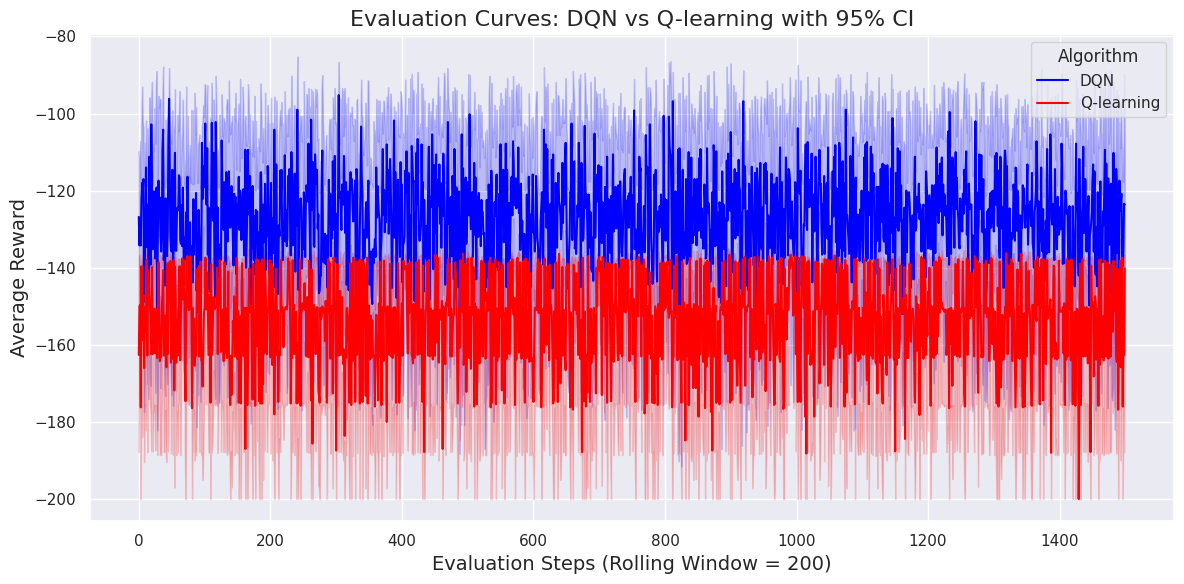

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prepare_data_for_seaborn(d_list, q_list):
    all_data = []
    
    for run_idx, run_data in enumerate(d_list):
        for step_idx, reward in enumerate(run_data):
            all_data.append({
                'Algorithm': 'DQN',
                'Run': run_idx,
                'Step': step_idx,
                'Reward': reward
            })
    
    for run_idx, run_data in enumerate(q_list):
        for step_idx, reward in enumerate(run_data):
            all_data.append({
                'Algorithm': 'Q-learning',
                'Run': run_idx,
                'Step': step_idx,
                'Reward': reward
            })
    
    return pd.DataFrame(all_data)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

df = prepare_data_for_seaborn(d_list, q_list)

sns.lineplot(
    data=df,
    x='Step',
    y='Reward',
    hue='Algorithm',
    errorbar=('ci', 95),
    palette=['blue', 'red']
)

plt.title('Evaluation Curves: DQN vs Q-learning with 95% CI', fontsize=16)
plt.xlabel('Evaluation Steps (Rolling Window = 200)', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.legend(title='Algorithm')

plt.tight_layout()
plt.show()